# FAIR

This notebook gives some simple examples of how to run and use the Finite Amplitude Impulse Response (FAIR) model. 

The  Finite  Amplitude  Impulse  Response  (FAIR)  model  is  a  simple  climate model. It allows the user to prescribed CO$_2$ emissions or radiative forcing, non-CO$_2$ radiative forcing and climate and carbon cycle parameters in order to estimate global mean atmospheric CO$_2$ concentrations, radiative forcing and temperature anomalies.


It was developed by Richard Millar, Zebedee Nicholls, Pierre Friedlingstein and Myles Allen. The motivation for developing it and its formulation is documented in  a  paper  published  in  Atmospheric  Chemistry  and  Physics  in  2017 (doi:10.5194/acp-2016-405).

In [1]:
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.figsize'] = 16, 9
plt.rcParams['lines.linewidth'] = 1.5

font = {'weight' : 'normal',
      'size'   : 12}

plt.rc('font', **font)

import fair
fair.__version__

'1.0.1'

## Basic run
Here we show how FAIR can be run with step change CO$_2$ emissions and sinusoidal non-CO$_2$ forcing timeseries.

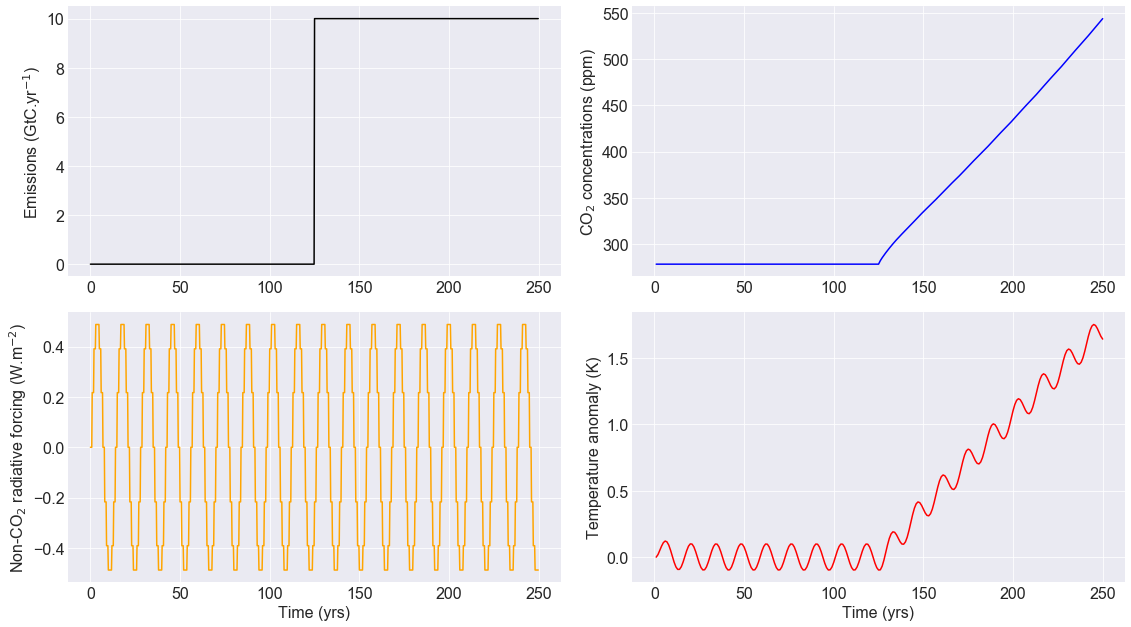

In [2]:
emissions = np.zeros(250)
emissions[125:] = 10.0
other_rf = np.zeros(emissions.size)
for x in range(0,emissions.size):
    other_rf[x] = 0.5*np.sin(2*np.pi*(x)/14.0)

C,T = fair.forward.fair_scm(emissions=emissions,
                            other_rf=other_rf)

fig,ax1,ax2,ax3,ax4 = fair.forward.plot_fair(emissions,C,other_rf,T,tuts='yrs')
fig.tight_layout()

## Emissions only
We can also run FAIR with just CO$_2$ emissions and no forcing.

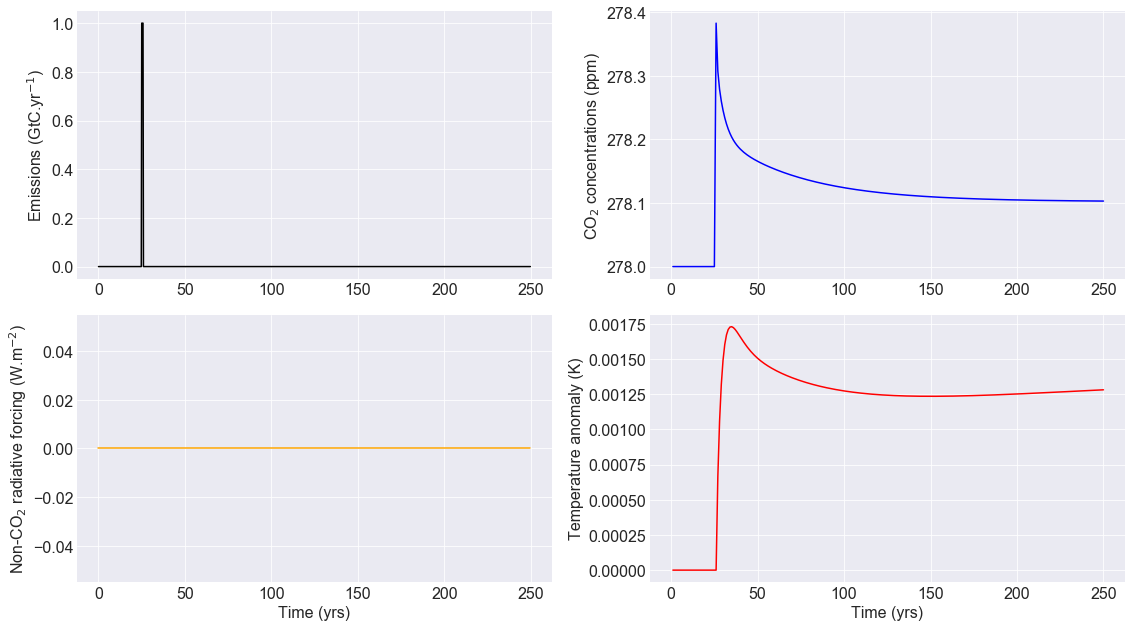

In [3]:
emissions = np.zeros(250)
emissions[25] = 1.0
other_rf = 0.0
C,T = fair.forward.fair_scm(emissions=emissions,
                            other_rf=other_rf)

fig,ax1,ax2,ax3,ax4 = fair.forward.plot_fair(emissions,C,other_rf,T,tuts='yrs')
fig.tight_layout()

## Forcing only
Or we can set emissions to zero and just have radiative forcing. Here we simply have a step change in radiative forcing from 0.0 W.m$^{-2}$ to RF$_{2 \times CO_2} = 3.74$ W.m$^{-2}$

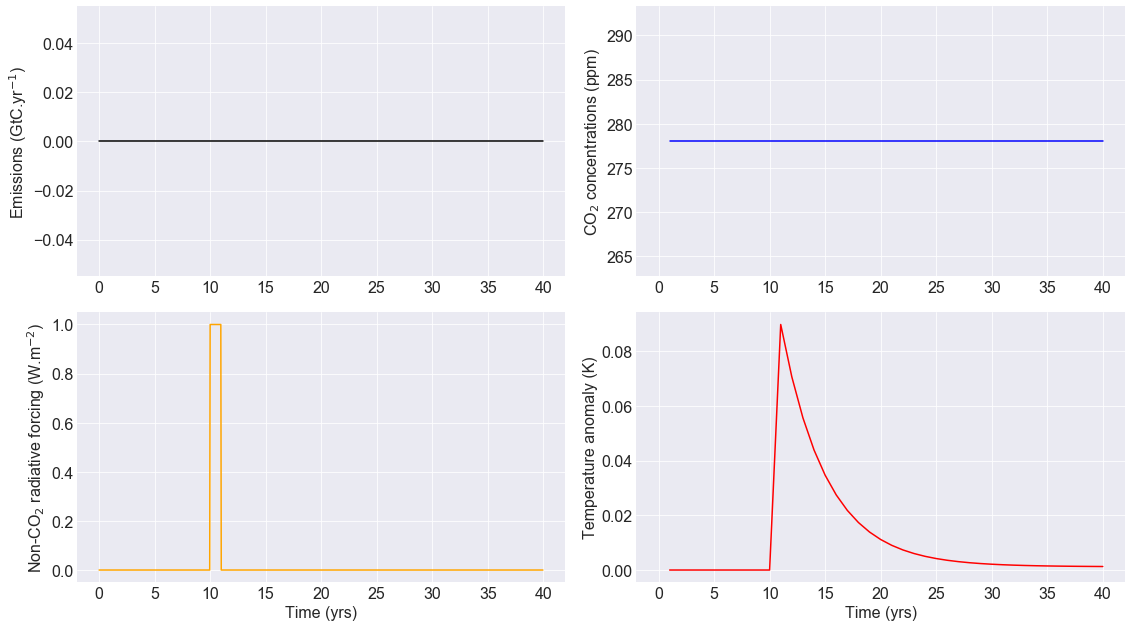

In [4]:
emissions = False
other_rf = np.zeros(40)
other_rf[10] = 1.0

C,T = fair.forward.fair_scm(emissions=emissions,
                            other_rf=other_rf)
fig,ax1,ax2,ax3,ax4 = fair.forward.plot_fair(emissions,C,other_rf,T,tuts='yrs')
fig.tight_layout()

# ECS and TCR


Here we perform a 1% per year increase in CO$_2$ concentration with stabilisation experiment to confirm that our input values of ECS and TCR actually manifest.

CO2 levels capped at: 556.0329ppmv
Diagnosed TCR: 1.6001K
Diagnosed ECS: 2.7499K


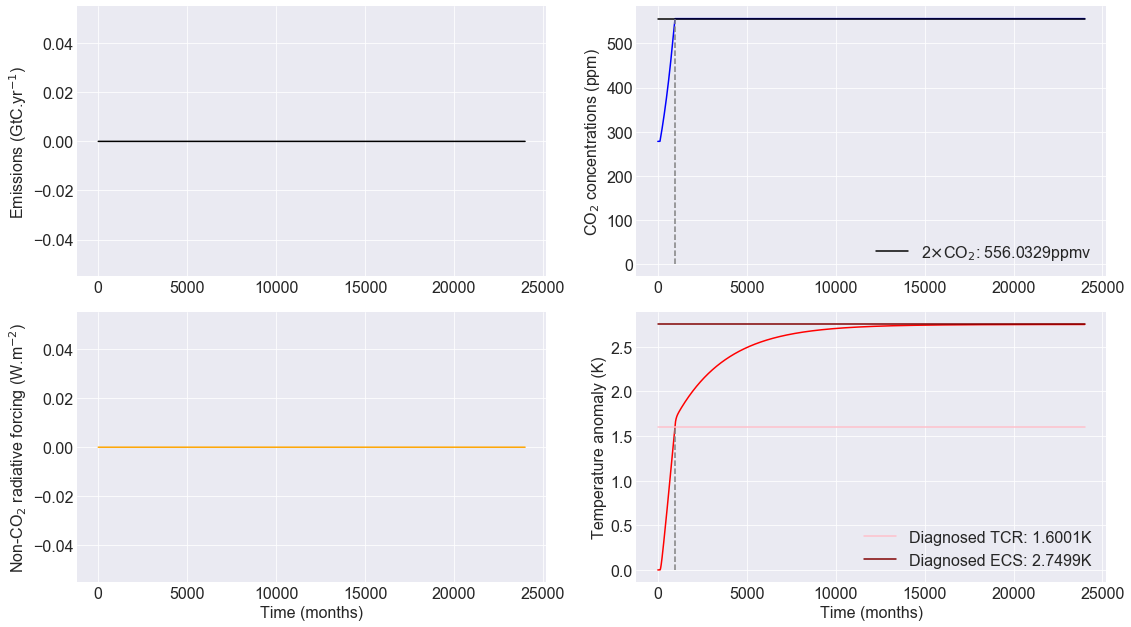

In [5]:
# To get the doubling slightly more accurate, we use a monthly
# concentrations time series rather than an annual one

co2_concs = np.zeros(2000*12)
C_0 = 278.0
# set number of months of pre-industrial concs
pic = 120
# CO2 concentrations double in August of year 69 of the 1% per year increase
dblt = 12*69+8
co2_concs[0:pic] = C_0
co2_concs[pic:pic + dblt + 1] = C_0*(1.01**(np.arange(0,dblt+1)/12.0))

print 'CO2 levels capped at: {0:.4f}ppmv'.format(co2_concs[pic+dblt])
co2_concs[pic + dblt:] = co2_concs[pic + dblt]

input_params = np.array([0.33,0.41,1.6,2.75,239.0,4.1,0.2173,0.2240,0.2824,0.2763,1000000,394.4,36.54,4.304,32.40,0.019,4.165,3.74,278.0,2.123,97.0])
input_params[18] = C_0
input_params[2] = 1.6
input_params[3] = 2.75

C,T = fair.forward.fair_scm(tstep=(1/12.0),
                            co2_concs=co2_concs,
                            input_params=input_params)

fig,ax1,ax2,ax3,ax4 = fair.forward.plot_fair(0.0,C,0.0,T,tuts='months')

ax2.plot([0,len(C)],[2*C_0,2*C_0],color='black',label=r'2$\times$CO$_2$: {0:.4f}ppmv'.format(co2_concs[12*79+8]))
ax2.plot([pic+dblt,pic+dblt],[0.0,2.0*C_0],color='grey',ls='--')
ax2.legend()

ax4.plot([0,len(C)],[T[pic+dblt+1],T[pic+dblt+1]],color='pink',label='Diagnosed TCR: {0:.4f}K'.format(T[pic+dblt+1]))
ax4.plot([pic+dblt,pic+dblt],[0.0,T[pic+dblt+1]],color='grey',ls='--')
ax4.plot([0,len(C)],[T[-1],T[-1]],color='maroon',label='Diagnosed ECS: {0:.4f}K'.format(T[-1]))
ax4.legend()

fig.tight_layout()

# In FAIR, the radiative forcing due to increases in CO2 concentrations
# isn't actually seen by the climate system until a year after they happen
# (see FAIR-maths.pdf for an explanation of why this has to be the case). 
# As a result, it's necessary to look at the temperature the year after CO2 
# concentrations double to determine TCS, rather than in the year of doubling,
# as this point represents the climate system's actual response to the 
# full linear increase in forcing. If we didn't do this, we'd be chopping off
# the last year of forcing.

print 'Diagnosed TCR: {0:.4f}K'.format(T[pic+dblt+1])
print 'Diagnosed ECS: {0:.4f}K'.format(T[-1])

The plot above isn't very illuminating so we can split our axes instead

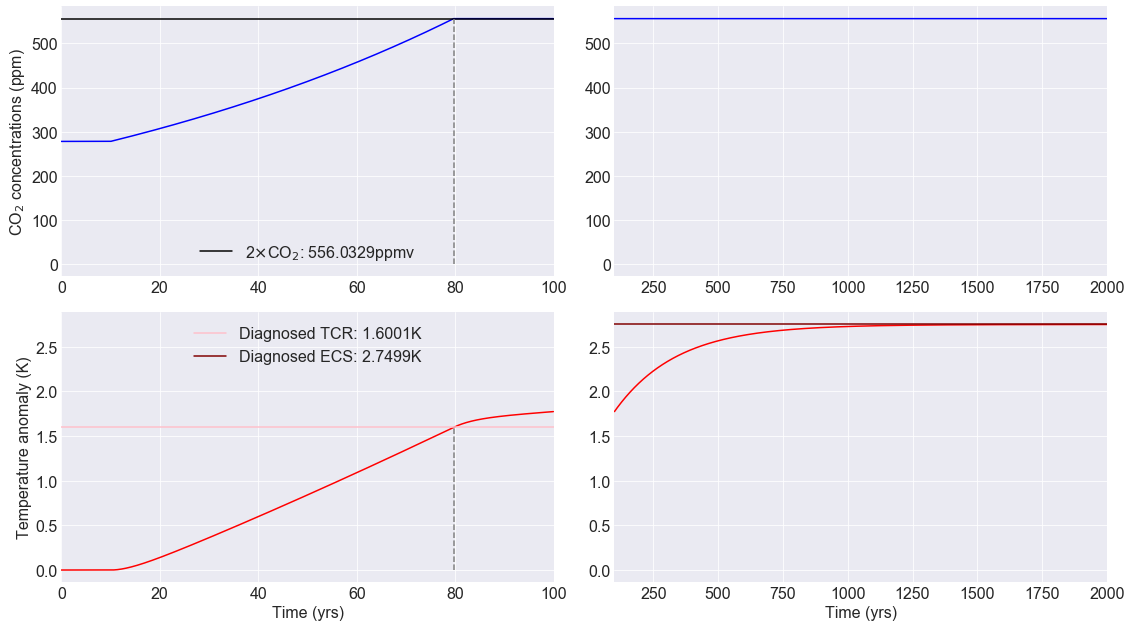

In [6]:
spltyr = 100
spltmon = spltyr*12

fig = plt.figure()

ax1 = fig.add_subplot(221)
ax1.plot(np.arange(0,spltmon)/12.0,C[:spltmon],color='blue')
ax1.plot([0,spltyr],[2*C_0,2*C_0],color='black',label=r'2$\times$CO$_2$: {0:.4f}ppmv'.format(co2_concs[12*79+8]))
ax1.plot([(pic+dblt)/12.0,(pic+dblt)/12.0],[0.0,2.0*C_0],color='grey',ls='--')
ax1.legend(loc='lower center')
ax1.set_ylabel('CO$_2$ concentrations (ppm)')
ax1.set_xlim([0,spltyr])

ax2 = fig.add_subplot(222, sharey=ax1)
ax2.plot(np.arange(spltmon,C.size)/12.0,C[spltmon:],color='blue')
ax2.set_ylabel('')

ax3 = fig.add_subplot(223)
ax3.plot(np.arange(0,spltmon)/12.0,T[:spltmon],color='red')
ax3.plot([(pic+dblt)/12.0,(pic+dblt)/12.0],[0.0,T[pic+dblt+1]],color='grey',ls='--')
lns = ax3.plot([0.0,spltyr],[T[pic+dblt+1],T[pic+dblt+1]],color='pink',label='Diagnosed TCR: {0:.4f}K'.format(T[pic+dblt+1]))
ax3.set_ylabel('Temperature anomaly (K)')
ax3.set_xlabel('Time (yrs)')
ax3.set_xlim([0,spltyr])

ax4 = fig.add_subplot(224, sharey=ax3,sharex=ax2)
ax4.plot(np.arange(spltmon,C.size)/12.0,T[spltmon:],color='red')
lns += ax4.plot([spltyr,C.size/12.0],[T[-1],T[-1]],color='maroon',label='Diagnosed ECS: {0:.4f}K'.format(T[-1]))

ax3.legend(lns,[l.get_label() for l in lns],loc='upper center')
ax4.set_xlabel('Time (yrs)')
ax4.set_ylabel('')
ax4.set_xlim([spltyr,C.size/12.0])
plt.tight_layout()

## RCPs

We can run FAIR with the CO$_2$ emissions and non-CO$_2$ forcing from the four representative concentration pathway scenarios

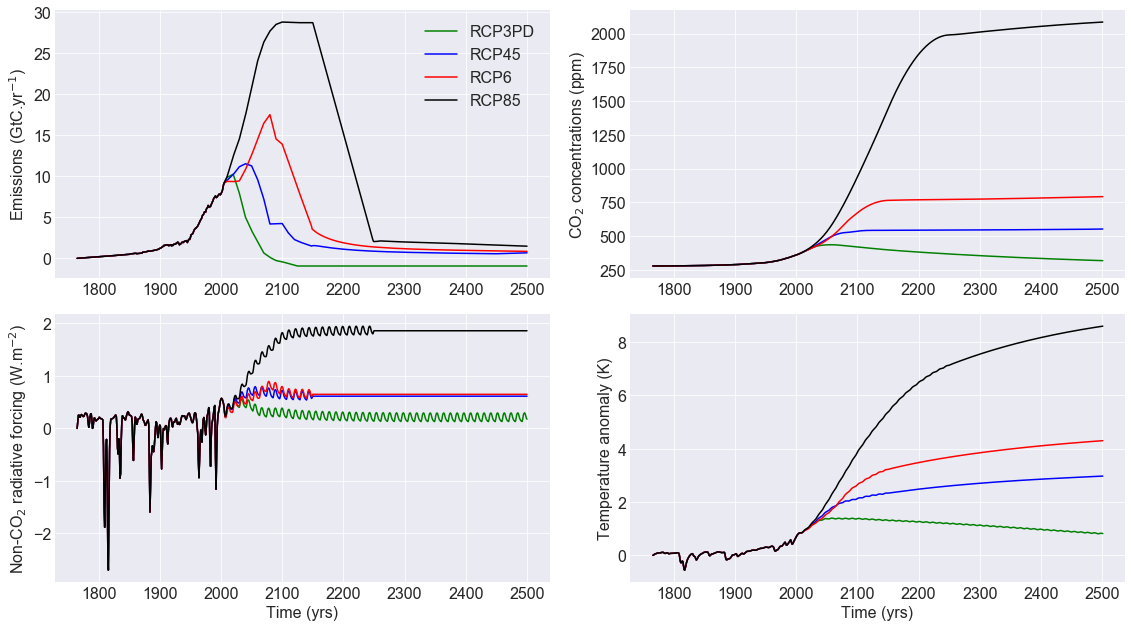

In [7]:
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

rcps = ['RCP3PD','RCP45','RCP6','RCP85']
colours = ['green','blue','red','black']

for i,rcp in enumerate(rcps):
    emms_file = './fair/RCPs/' + rcp + '_EMISSIONS.csv'
    emms_data = np.genfromtxt(emms_file,skip_header=36,delimiter=',',names=True)
    emissions = emms_data['FossilCO2'] + emms_data['OtherCO2']
    
    forc_file = './fair/RCPs/' + rcp + '_MIDYEAR_RADFORCING.csv'
    forc_data = np.genfromtxt(forc_file,skip_header=58,delimiter=',',names=True)
    other_rf = forc_data['TOTAL_INCLVOLCANIC_RF'] - forc_data['CO2_RF']
    
    C,T = fair.forward.fair_scm(emissions=emissions,
                            other_rf=other_rf)
    
    fair.forward.plot_fair(emissions,
              C,
              other_rf,
              T,
              y_0=1765,
              tuts='yrs',
              infig=fig,
              inemmsax=ax1,
              inconcax=ax2,
              inforcax=ax3,
              intempax=ax4,
              colour={'emms':colours[i],
                     'conc':colours[i],
                     'forc':colours[i],
                     'temp':colours[i]},
              label=rcp
             )

## RCPs with uncertainty

We can run FAIR with the CO$_2$ emissions and non-CO$_2$ forcing from the four representative concentration pathway scenarios with an uncertainty plume for concentrations, temperature and radiative forcing highlighting high and low responses.

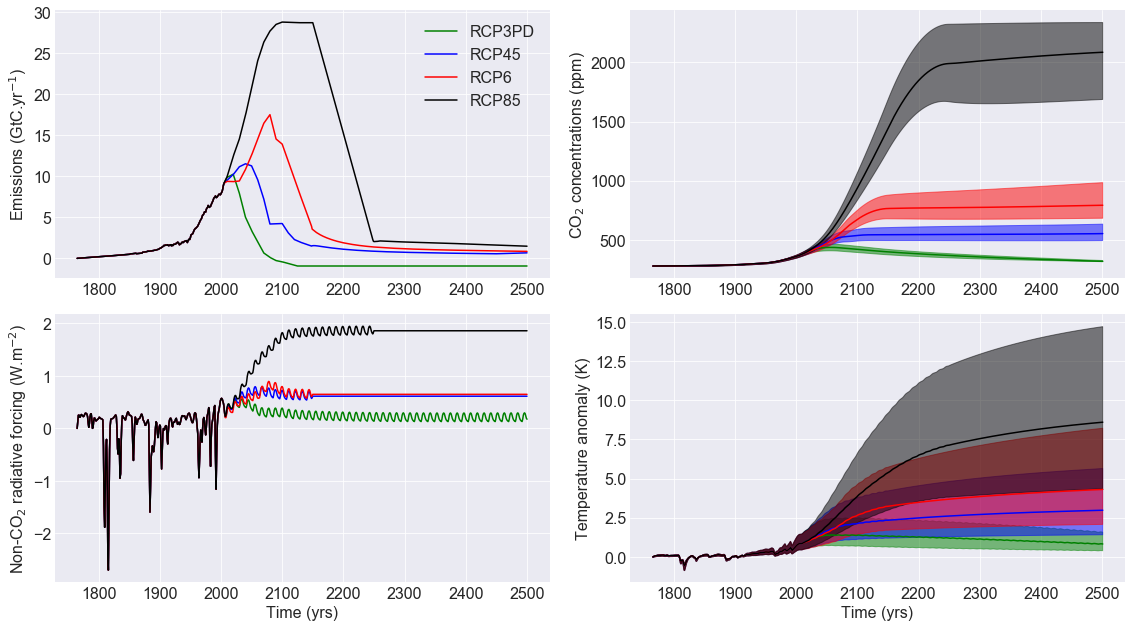

In [8]:
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

rcps = ['RCP3PD','RCP45','RCP6','RCP85']
colours = ['green','blue','red','black']
year0 = 1765
for i,rcp in enumerate(rcps):
    emms_file = './fair/RCPs/' + rcp + '_EMISSIONS.csv'
    emms_data = np.genfromtxt(emms_file,skip_header=36,delimiter=',',names=True)
    rcp_emissions = emms_data['FossilCO2'] + emms_data['OtherCO2']
    
    forc_file = './fair/RCPs/' + rcp + '_MIDYEAR_RADFORCING.csv'
    forc_data = np.genfromtxt(forc_file,skip_header=58,delimiter=',',names=True)
    rcp_other_rf = forc_data['TOTAL_INCLVOLCANIC_RF'] - forc_data['CO2_RF']
    
    input_params=np.array([0.33,0.41,1.0,1.5,239.0,4.1,0.2173,0.2240,0.2824,0.2763,1000000,394.4,36.54,4.304,32.40*0.87,0.019*0.87,4.165*0.87,3.74,278.0,2.123,97.0])
    C_low,T_low = fair.forward.fair_scm(emissions=rcp_emissions,
                                        other_rf=rcp_other_rf,
                                        input_params=input_params)
    
    input_params=np.array([0.33,0.41,1.6,2.75,239.0,4.1,0.2173,0.2240,0.2824,0.2763,1000000,394.4,36.54,4.304,32.40,0.019,4.165,3.74,278.0,2.123,97.0])    
    C,T = fair.forward.fair_scm(emissions=rcp_emissions,
                                other_rf=rcp_other_rf,
                                input_params=input_params)
    
    input_params=np.array([0.33,0.41,2.5,4.5,239.0,4.1,0.2173,0.2240,0.2824,0.2763,1000000,394.4,36.54,4.304,32.40*1.13,0.019*1.13,4.165*1.13,3.74,278.0,2.123,97.0])    
    C_high,T_high = fair.forward.fair_scm(emissions=rcp_emissions,
                                          other_rf=rcp_other_rf,
                                          input_params=input_params)
    
    fair.forward.plot_fair(rcp_emissions,
          C,
          rcp_other_rf,
          T,
          y_0=year0,
          tuts='yrs',
          infig=fig,
          inemmsax=ax1,
          inconcax=ax2,
          inforcax=ax3,
          intempax=ax4,
          colour={'emms':colours[i],
                 'conc':colours[i],
                 'forc':colours[i],
                 'temp':colours[i]},
          label=rcp
         )
    
    ax2.fill_between(range(year0,year0+emissions.size),C_low,C_high,color=colours[i],alpha=0.5)
    ax4.fill_between(range(year0,year0+emissions.size),T_low,T_high,color=colours[i],alpha=0.5)

## Carbon cycle range

Here we provide code that approximately produces figure 4b from Millar et al. to show how FAIR parameters can be modified so that it can reproduce the carbon cycle response of more complex models.

Producing figure 4 as it was done in the paper requires the ability to prescribe temperature timeseries to FAIR as well as back out emissions from concentrations so will only be given in the 'FAIRPro' package.

### Read Joos et al. data into a dictionary structure

We read the data into a dictionary structure of the following form

```
JPI100 = {'name':{'AF_timeseries':timeseries}}

JPI100: (dictionary)
  Dictionary of Joos et al. PI100 data. Each element must have the 
  following substructure:
    ['model-name']: (dictionary)
      The data for 'model-name'
      It must have the following sub structure:
        ['AF_ts']: (numpy array) - airborne fraction timeseries
        ['year']: (numpy array) - time
        ['iIRF100']: (float) - 100 year integrated impulse response
```

In [9]:
# read in Joos et al data (doi:10.5194/acp-13-2793-2013, 2013) 
Joos_PI100_CO2_fn = "./fair/Millar-et-al-4-data/IRF_PI100_SMOOTHED_CO2.csv"
Joos_PI100_CO2 = np.genfromtxt(Joos_PI100_CO2_fn,
                               skip_header=17,
                               delimiter=',',
                               names=True)
JPI100 = {}

# also create a list of iIRF100 values so we can plot in that order later
iIRF100ls = []
for key in Joos_PI100_CO2.dtype.names:
    if (key == 'YEAR') | (key == 'MULTIMODEL_STDEV'):
        pass
    elif Joos_PI100_CO2[key][0] > 1000:
        print key
        print 'PI dud data'    
    else:
        JPI100[key] = {}
        JPI100[key]['year'] = Joos_PI100_CO2['YEAR']
        JPI100[key]['AF_ts'] = Joos_PI100_CO2[key]*2.123/100.0
        JPI100[key]['iIRF100'] = np.sum(Joos_PI100_CO2[key][0:100]*2.123/100.0)
        iIRF100ls.append(JPI100[key]['iIRF100'])

# sort our iIRF100 list
iIRF100ls.sort()

# read in FAIR fitting parameters
Ffitpfn = './fair/Millar-et-al-4-data/example-FAIR-fit-parameters.csv'
Ffitp = np.genfromtxt(Ffitpfn,
                      delimiter=',',
                      skip_header=0,
                      names=True,
                      dtype=['S50']+['f8']*9)

### Make the plot

/Users/OllieBraddy/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


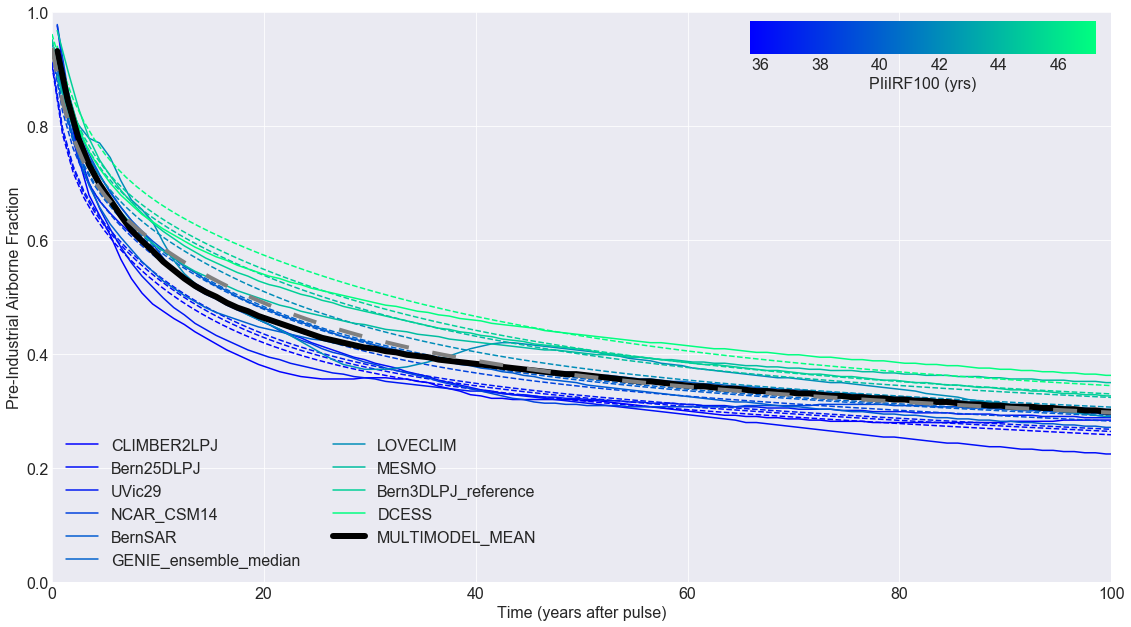

In [10]:
# illustrate FAIR's emulation ability
from matplotlib.colors import Normalize, rgb2hex
from matplotlib.colorbar import ColorbarBase

# set up figure
fig = plt.figure()
ax = fig.add_subplot(111)

# create our colour bar
cmapPI=plt.get_cmap('winter')
normsPI = Normalize(min(iIRF100ls),max(iIRF100ls))
ax2a = fig.add_axes([0.66, 0.90, 0.3, 0.05])
# ColorbarBase derives from ScalarMappable and puts a colorbar
# in a specified axes, so it has everything needed for a
# standalone colorbar.  There are many more kwargs, but the
# following gives a basic continuous colorbar with ticks
# and labels.
cb2 = ColorbarBase(ax2a, 
                   cmap=cmapPI,
                   norm=normsPI,
                   orientation='horizontal',
                   label='PIiIRF100 (yrs)')

# emissions timeseries and C_0 for FAIR runs
emissions = np.zeros(101)
emissions[0] = 100
C_0=278.0

for iIRF100 in iIRF100ls:
    # determine our model
    key = [key for key in JPI100 if JPI100[key]['iIRF100'] == iIRF100][0]
    
    if key != 'MULTIMODEL_MEAN':
        # choose colour based off iIRF100 value
        col = rgb2hex(cmapPI(normsPI(iIRF100)))
        lw = 1.5
        
        # plot our timeseries
        ax.plot(JPI100[key]['year'],
                JPI100[key]['AF_ts'],
                label=key,
                color=col,
                ls='-',
                lw=lw)
        
        # plot FAIR run using appropriate fitting parameters
        r0=Ffitp['r0'][Ffitp['Model'] == key][0]
        rC=Ffitp['rC'][Ffitp['Model'] == key][0]
        rT=Ffitp['rT'][Ffitp['Model'] == key][0]
        a=[Ffitp['a{0}'.format(j)][Ffitp['Model'] == key][0] for j in range(0,4)]
        C_0=278.0
        input_params=np.array([0.33,0.41,1.6,2.75,239.0,4.1,0.2173,0.2240,0.2824,0.2763,1000000,394.4,36.54,4.304,32.40,0.019,4.165,3.74,278.0,2.123,97.0])
        input_params[14]=r0
        input_params[15]=rC
        input_params[16]=rT
        input_params[6:10]=np.array(a)
        input_params[0]=C_0
        C,T = fair.forward.fair_scm(emissions=emissions,
                                    other_rf=0.0,
                                    input_params=input_params)
        
        ax.plot(range(0,len(emissions)),
                (C-C_0)*2.123/100.0,
                color=col,
                ls='--',
                lw=lw)

# lastly plot multimodel mean
key = 'MULTIMODEL_MEAN'
col = 'black'
lw = 6.0
ax.plot(JPI100[key]['year'],
        JPI100[key]['AF_ts'],
        label=key,
        color=col,
        ls='-',
        lw=lw)

# plot FAIR run using appropriate fitting parameters
r0=Ffitp['r0'][Ffitp['Model'] == key][0]
rC=Ffitp['rC'][Ffitp['Model'] == key][0]
rT=Ffitp['rT'][Ffitp['Model'] == key][0]
a=[Ffitp['a{0}'.format(j)][Ffitp['Model'] == key][0] for j in range(0,4)]

input_params=np.array([0.33,0.41,1.6,2.75,239.0,4.1,0.2173,0.2240,0.2824,0.2763,1000000,394.4,36.54,4.304,32.40,0.019,4.165,3.74,278.0,2.123,97.0])
input_params[14]=r0
input_params[15]=rC
input_params[16]=rT
input_params[6:10]=np.array(a)
input_params[0]=C_0
C,T = fair.forward.fair_scm(emissions=emissions,
                            other_rf=0.0,
                            input_params=input_params)

ax.plot(range(0,len(emissions)),
        (C-C_0)*2.123/100.0,
        color='grey',
        ls='--',
        dashes=(6,6),
        lw=lw-2)

# add labels etc
ax.set_xlabel('Time (years after pulse)')
ax.set_ylabel('Pre-Industrial Airborne Fraction')
ax.set_ylim([0,1])
ax.set_xlim([0,100])
ax.legend(ncol=2)

plt.tight_layout()   

### Fit for a single model

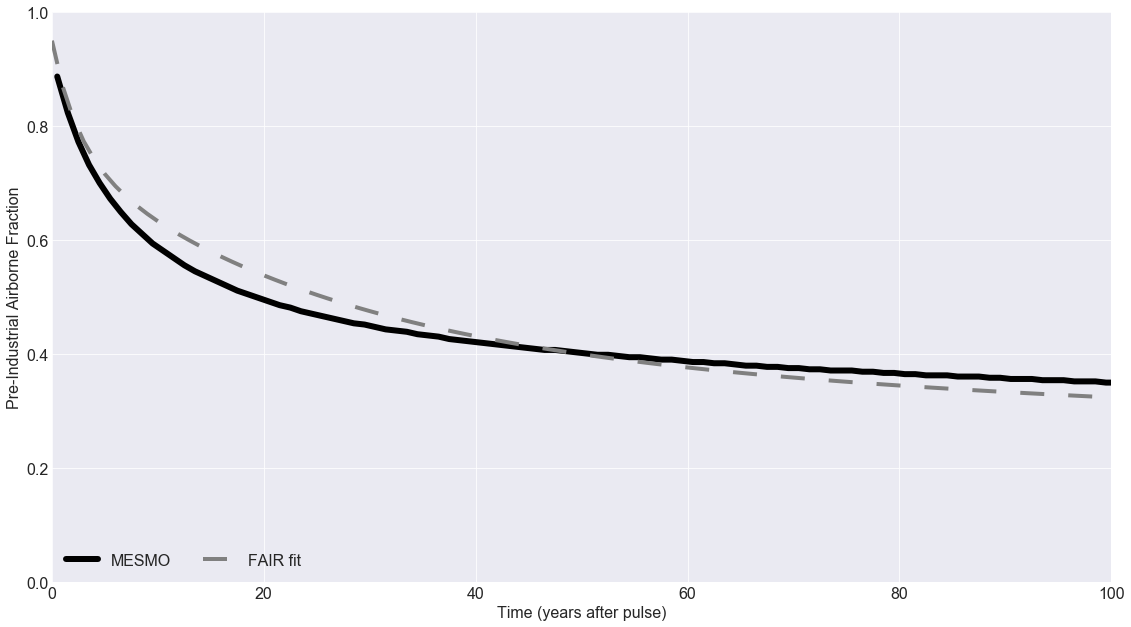

In [11]:
# set up figure
fig = plt.figure()
ax = fig.add_subplot(111)

# emissions timeseries and C_0 for FAIR run
emissions = np.zeros(101)
emissions[0] = 100
C_0=278.0

# choose our model
# options (can be printed with `print [key for key in JPI100]`): 
# 'CLIMBER2LPJ', 'GENIE_ensemble_median', 'Bern3DLPJ_reference', 'NCAR_CSM14', 'UVic29', 'LOVECLIM', 'BernSAR', 
# 'MULTIMODEL_MEAN', 'DCESS', 'Bern25DLPJ', 'MESMO'
key = 'MESMO'

# plot
lw = 6.0
ax.plot(JPI100[key]['year'],
    JPI100[key]['AF_ts'],
    label=key,
    color='black',
    ls='-',
    lw=lw)

# plot FAIR run using appropriate fitting parameters
r0=Ffitp['r0'][Ffitp['Model'] == key][0]
rC=Ffitp['rC'][Ffitp['Model'] == key][0]
rT=Ffitp['rT'][Ffitp['Model'] == key][0]
a=[Ffitp['a{0}'.format(j)][Ffitp['Model'] == key][0] for j in range(0,4)]

input_params=np.array([0.33,0.41,1.6,2.75,239.0,4.1,0.2173,0.2240,0.2824,0.2763,1000000,394.4,36.54,4.304,32.40,0.019,4.165,3.74,278.0,2.123,97.0])
input_params[14]=r0
input_params[15]=rC
input_params[16]=rT
input_params[6:10]=np.array(a)
input_params[0]=C_0
C,T = fair.forward.fair_scm(emissions=emissions,
                            other_rf=0.0,
                            input_params=input_params)

ax.plot(range(0,len(emissions)),
    (C-C_0)*2.123/100.0,
    color='grey',
    ls='--',
    dashes=(6,6),
    lw=lw-2,
    label='FAIR fit')

# add labels etc
ax.set_xlabel('Time (years after pulse)')
ax.set_ylabel('Pre-Industrial Airborne Fraction')
ax.set_ylim([0,1])
ax.set_xlim([0,100])
ax.legend(ncol=2)

plt.tight_layout()   

### Make a panel plot for each model

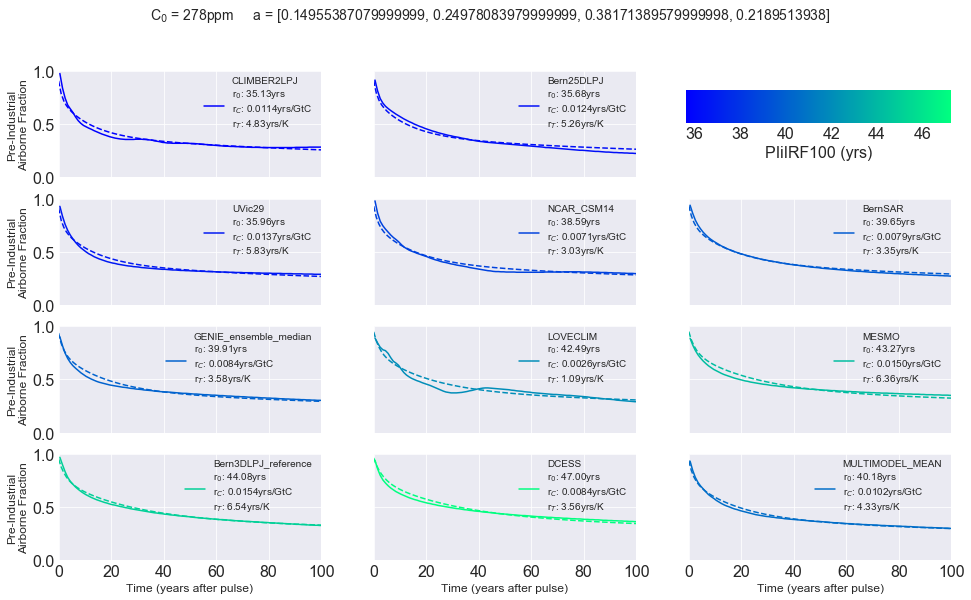

In [12]:
# illustrate FAIR's emulation ability
from matplotlib.colors import Normalize, rgb2hex
from matplotlib.colorbar import ColorbarBase

# set up figure
fig = plt.figure()

# create our colour bar
cmapPI=plt.get_cmap('winter')
normsPI = Normalize(min(iIRF100ls),max(iIRF100ls))

# emissions timeseries and C_0 for FAIR runs
emissions = np.zeros(101)
emissions[0] = 100
C_0=278.0

ij = 0
nrows = 4
ncols = 3
for iIRF100 in iIRF100ls:
    # determine our model
    key = [key for key in JPI100 if JPI100[key]['iIRF100'] == iIRF100][0]

    ij += 1
    if ij == 3:
        ij += 1
    if key == 'MULTIMODEL_MEAN':
        pij = ij - 1
        ij = nrows * ncols
        
    ax = fig.add_subplot(nrows,ncols,ij)
    
    # choose colour based off iIRF100 value
    col = rgb2hex(cmapPI(normsPI(iIRF100)))
    lw = 1.5

    # run FAIR using appropriate fitting parameters
    r0=Ffitp['r0'][Ffitp['Model'] == key][0]
    rC=Ffitp['rC'][Ffitp['Model'] == key][0]
    rT=Ffitp['rT'][Ffitp['Model'] == key][0]
    a=[Ffitp['a{0}'.format(j)][Ffitp['Model'] == key][0] for j in range(0,4)]
    C_0=278.0
    input_params=np.array([0.33,0.41,1.6,2.75,239.0,4.1,0.2173,0.2240,0.2824,0.2763,1000000,394.4,36.54,4.304,32.40,0.019,4.165,3.74,278.0,2.123,97.0])
    input_params[14]=r0
    input_params[15]=rC
    input_params[16]=rT
    input_params[6:10]=np.array(a)
    input_params[0]=C_0
    C,T = fair.forward.fair_scm(emissions=emissions,
                            other_rf=0.0,
                            input_params=input_params)

    #   plot our timeseries
    ax.plot(JPI100[key]['year'],
            JPI100[key]['AF_ts'],
            color=col,
            ls='-',
            label='{0}\nr$_0$: {1:.2f}yrs\nr$_C$: {2:.4f}yrs/GtC\nr$_T$: {3:.2f}yrs/K'.format(key,r0,rC,rT),
            lw=lw)
    
    ax.plot(range(0,len(emissions)),
            (C-C_0)*2.123/100.0,
            color=col,
            ls='--',
            lw=lw)

    ax.legend(ncol=2,loc='upper right',fontsize=10)
    
    # add labels etc
    # start of rows gets a y label
    if ij % ncols == 1:
        ax.set_ylabel('Pre-Industrial\nAirborne Fraction',fontsize=12)
    # everything else gets labels turned off
    else:
        ax.set_yticklabels([' ' for item in ax.get_yticklabels()])
    # last row gets an xlabel
    if ij > (nrows-1)*ncols:
        ax.set_xlabel('Time (years after pulse)',fontsize=12)
    else:
        ax.set_xticklabels([' ' for item in ax.get_xticklabels()])
    # set axis limits
    ax.set_ylim([0,1])
    ax.set_xlim([0,100])
        
    if key == 'MULTIMODEL_MEAN':
        ij = pij
        
# plot our colour bar
ax2a = fig.add_axes([0.67, 0.80, 0.23, 0.05])
# ColorbarBase derives from ScalarMappable and puts a colorbar
# in a specified axes, so it has everything needed for a
# standalone colorbar.  There are many more kwargs, but the
# following gives a basic continuous colorbar with ticks
# and labels.
cb2 = ColorbarBase(ax2a, 
                   cmap=cmapPI,
                   norm=normsPI,
                   orientation='horizontal',
                   label='PIiIRF100 (yrs)')

fig.suptitle('C$_0$ = {0:.0f}ppm     a = {1}'.format(C_0,a),
             fontsize=14)

## Timestepping

Firstly, show that timestepping in FAIR produces the same results as a 'continuous' run. 

(<matplotlib.figure.Figure at 0x10ecae750>,
 <matplotlib.axes._subplots.AxesSubplot at 0x111776610>)

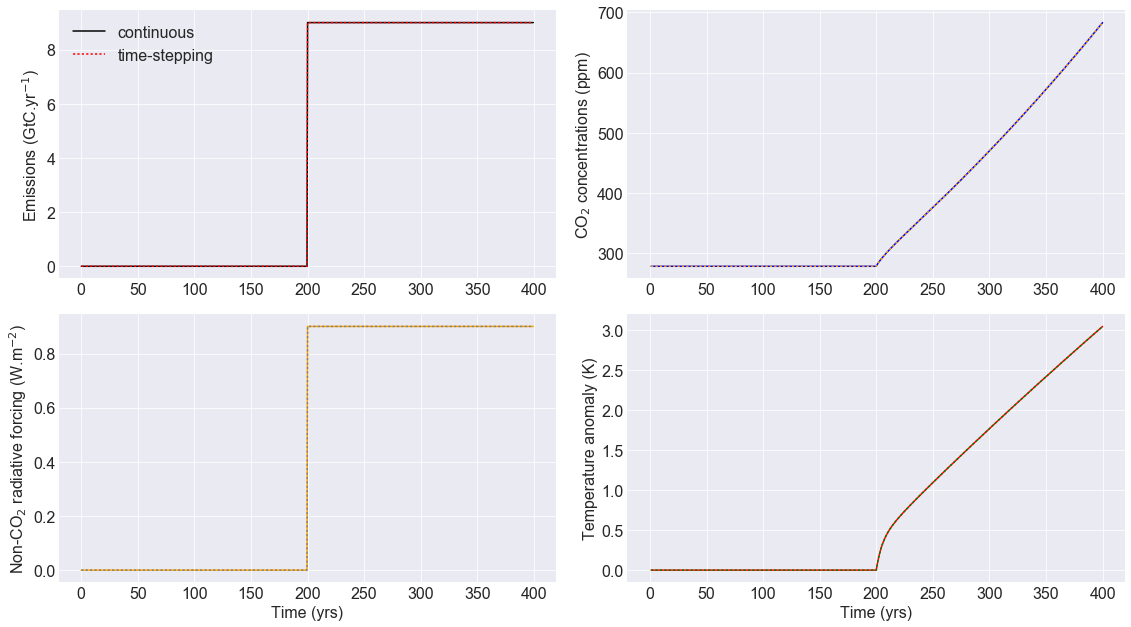

In [13]:
rlength = 400
emissionsc = np.zeros(rlength)
emissionsc[rlength/2:] = 9.0
other_rfc = np.zeros_like(emissionsc)
other_rfc[rlength/2:] = 0.9

Ca,Ta = fair.forward.fair_scm(
                           emissions=emissionsc,
                           other_rf=other_rfc,
                              )

fig,ax1,ax2,ax3,ax4 = fair.forward.plot_fair(emissionsc,Ca,other_rfc,Ta,tuts='yrs',label='continuous')

emissions = np.array([0.0])
other_rf = 0.0
restart = ([0.0,0.0,0.0,0.0],[0.0,0.0],0.0)

# start lists to store output timeseries
allt_emissions = []
allt_other_rf = []
allt_concentrations = []
allt_temperature = []

for j in range(0,rlength):
    # make our decision about whether to emit more or less
    if (j>=rlength/2):
            emissions[0] = 9.0
            other_rf = 0.9
        
    # timestep FAIR
    C,T,restart = fair.forward.fair_scm(
                           emissions=emissions,
                           other_rf=other_rf,
                           in_state=restart,
                           restart_out=True
                                        )
    # store the result
    allt_emissions.append(emissions[0])
    allt_other_rf.append(other_rf)
    allt_concentrations.append(C)
    allt_temperature.append(T)

fair.forward.plot_fair(allt_emissions,
                       allt_concentrations,
                       allt_other_rf,
                       allt_temperature,
                       tuts='yrs',
                       infig=fig,
                       inemmsax=ax1,
                       inconcax=ax2,
                       inforcax=ax3,
                       intempax=ax4,
                       colour={'emms':'red',
                             'conc':'orange',
                             'forc':'grey',
                             'temp':'green'},
                       label='time-stepping',
                       linestyle=':')

Here we use the timestepping capability built into FAIR to see what happens if we apply a simple criteria to emissions in each year based off observed warming to date.

(<matplotlib.figure.Figure at 0x1044c4610>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10fc46050>)

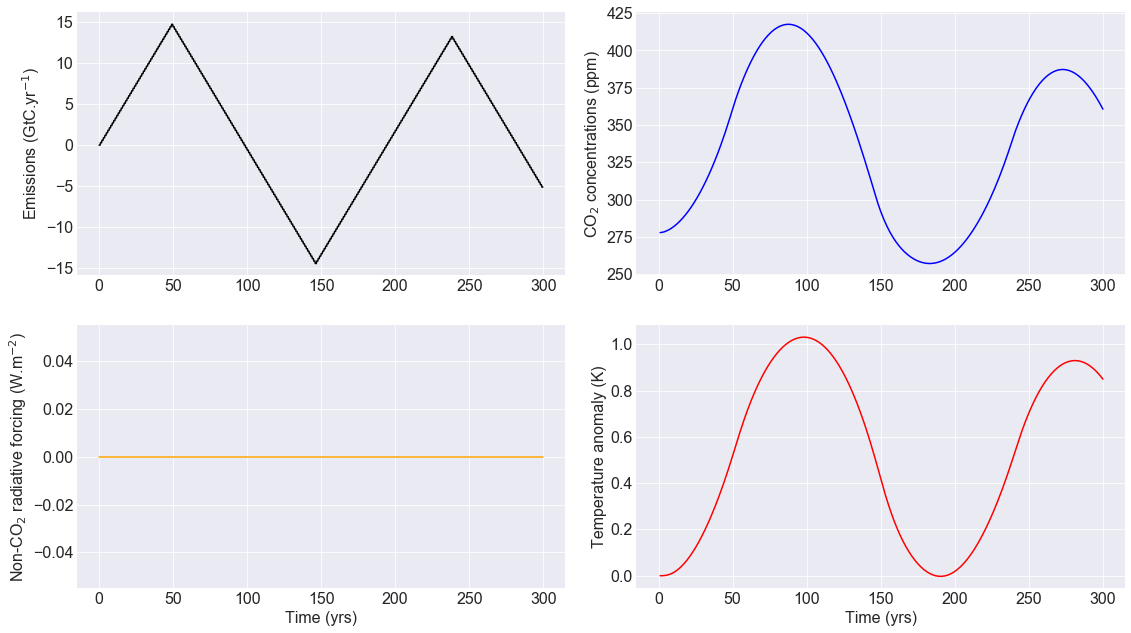

In [14]:
emissions = np.array([0.0])
other_rf = 0.0
restart = ([0.0,0.0,0.0,0.0],[0.0,0.0],0.0)

# start lists to store output timeseries
allt_emissions = []
allt_concentrations = []
allt_other_rf = []
allt_temperature = []

for j in range(0,300):
    # make our decision about whether to emit more or less
    if (j>=1):
        if (T > 0.5):
            emissions[0] -= 0.3
        else:
            emissions[0] += 0.3
        
    # timestep FAIR
    C,T,restart = fair.forward.fair_scm(
                           emissions=emissions,
                           other_rf = other_rf,
                           in_state=restart,
                           restart_out=True
                                        )
    # store the result
    allt_emissions.append(emissions[0])
    allt_concentrations.append(C)
    allt_other_rf.append(other_rf)
    allt_temperature.append(T)

fair.forward.plot_fair(allt_emissions,
                       allt_concentrations,
                       allt_other_rf,
                       allt_temperature,
                       tuts='yrs',
                       )